In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.stats
# basic imports

from IPython import display
%matplotlib inline

In [15]:
# this program illustrates how the outliers could be treated in the
# ML fit

# model
def model(p, x):
    return (
        p[0] + p[1] * x + 5 * np.sin(x / p[2])
    )

In [16]:
ptrue = [1, 4, 2]
def gendata():
    # Our True model 1+ 4 * x + 5 * sin(x/2)

    npoints = 60
    minx, maxx = 0, 20
    xs = np.random.uniform(minx, maxx, npoints)
    ys = model(ptrue, xs)
    # error-free data

    errs = np.random.uniform(0.1, 1, npoints)

    ys = ys + np.random.normal(size=npoints) * errs
    # perturb the data by the errors

    # introduce outliers
    outliers = np.random.uniform(-40, 40, npoints)
    outlier_fraction = 0.15

    subset = np.random.uniform(size=npoints) < outlier_fraction
    # subset of points which we'll make as outliers

    ys[subset] = ys[subset] + outliers[subset]

    plt.errorbar(xs, ys, errs, fmt='.')
    #oplot(np.linspace(minx,maxx), model(ptrue,np.linspace(minx,maxx)),color='red')
    plt.draw()
    return xs,ys,errs

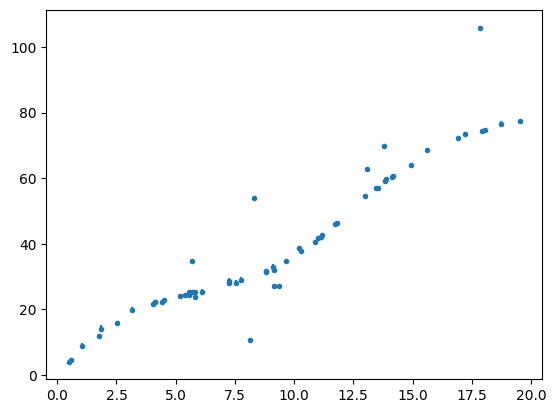

In [17]:
np.random.seed(3)
gendata();

In [18]:
# old likelihood function
def like1(p, xdat, ydat, errdat):
    # p are the function parameters

    ymod = model(p, xdat)

    lprob = scipy.stats.norm(ymod, errdat).logpdf(ydat)
    # probabilities of the data under Gaussian distribution

    like = -lprob.sum()

    if True:
        doplot(p, xdat, ydat, errdat)

    print (p, like)
    return like

In [19]:
# likelihood function for model with outliers
def like_outlier(p, xdat, ydat, errdat):
    # p are the function parameters

    pmodel = p[0:3] # parameters of the original model
    outlierfrac = p[3]    # fraction of dataset in outliers

    if outlierfrac < 0 or outlierfrac >= 1:
        return 1e10
        # we return very large number if fraction of outliers is
        # outside the [0,1] boundaries

    ymod = model(pmodel, xdat)

    # mixture of N(40,100) distribution and distribution centered
    # on model (ymod) values
    # this is not very accurate way of computing log-likelihood
    prob = ((1 - outlierfrac) *
            scipy.stats.norm(ymod,errdat).pdf(ydat) +
            outlierfrac *
            scipy.stats.norm(40,100).pdf(ydat)
            )
    logprob = np.log (prob + 1e-200)
    # we add tiny number to avoid log(0)


    # this is more accurate
    # alternative way of calculating logprobabilities
    # np.logaddexp (x,y) = np.log(np.exp(x)+np.exp(y)) # without loss of precision

    # computing the weigthed combination of probabilities
    # Assuming N(40,100) outlier model

    logprob = np.logaddexp(np.log(1 - outlierfrac) +
            scipy.stats.norm(ymod,errdat).logpdf(ydat),
            np.log(outlierfrac) +
            scipy.stats.norm(40,100).logpdf(ydat)
            )
    if True:
        if np.random.uniform()<.1:
           doplot(p, xdat, ydat, errdat)
    # probabilities of the data under Gaussian distribution

    like = - logprob.sum()
    # log probabilities

    print (p, like)

    return like

In [20]:
# Generate the data and fit the model
def run(simple_model=True):

    # generate the data
    xs,ys,errs=gendata()

    method = 'Nelder-Mead'

    if simple_model:
        p0 = [0.5, 3, 3]
        res = scipy.optimize.minimize(like1, p0, method=method,
                                      args=(xs, ys, errs))

    else:
        p0 = [0.5, 3, 3, 0.05]
        res = scipy.optimize.minimize(like_outlier, p0, method=method,
                                      args=(xs, ys, errs))

    return res

In [21]:
# plotting function
def doplot(p, xdat, ydat, errdat):

    ymod = model(p, xdat)

    plottype = 1
    # different convergence plots
    display.clear_output(wait=True)


    plt.clf()
    plt.errorbar(xdat, ydat, errdat, fmt='bo')
    plt.plot(np.linspace(0, 20), model(p, np.linspace(0, 20)), color='red')
    plt.draw()
    plt.pause(0.0001)
        # time.sleep(0.1)
    display.display(plt.gcf())

np.random.seed(1)

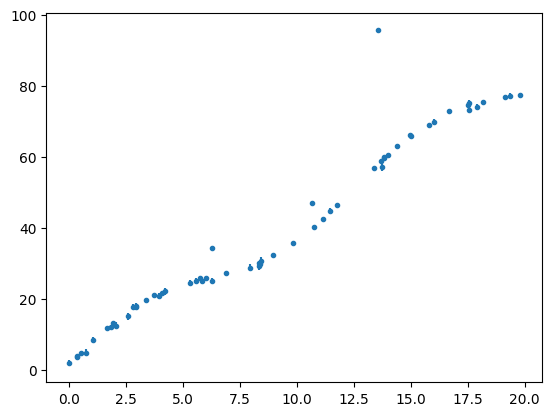

In [22]:
X,Y,E=gendata()

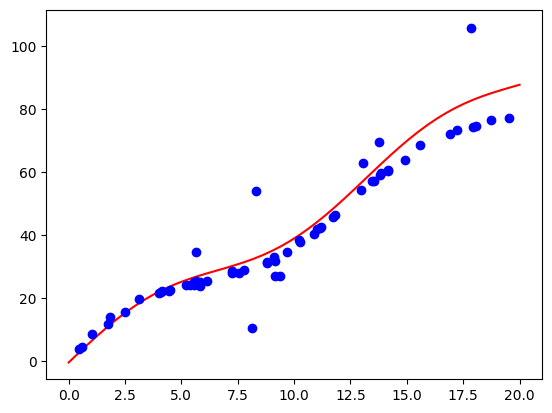

<Figure size 640x480 with 0 Axes>

[-0.39256666  4.43491097  2.09873315] 14443.560299142258


<Figure size 640x480 with 0 Axes>

In [23]:
# Run the original likelihood on the data with outliers
np.random.seed(3)
ret=run()

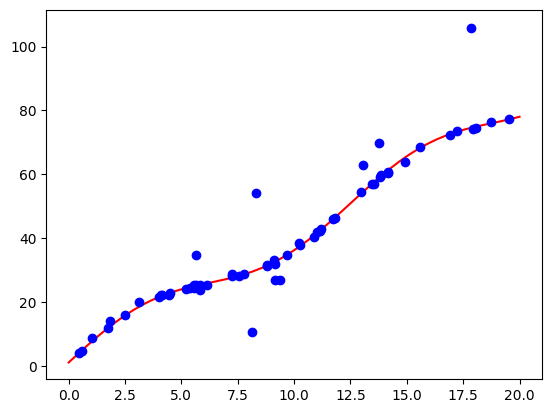

<Figure size 640x480 with 0 Axes>

[1.02314658 3.99240061 1.99307301 0.15146481] 103.23502000611279


<Figure size 640x480 with 0 Axes>

In [24]:
# Run a model with outliers
np.random.seed(3)
ret = run(False)

In [25]:
def run2():
    # illustration of the importance of the starting point
    # and choice of optimizer
    xs,ys,errs = gendata()

    method = 'Nelder-Mead'
    #method = 'L-BFGS-B'

    p0 = [3, 6, 6, 0.5]
    #p0 = [3, 3, 3, 0.5]

    res = scipy.optimize.minimize(like_outlier, p0, method=method,
                                      args=(xs, ys, errs))

    return res

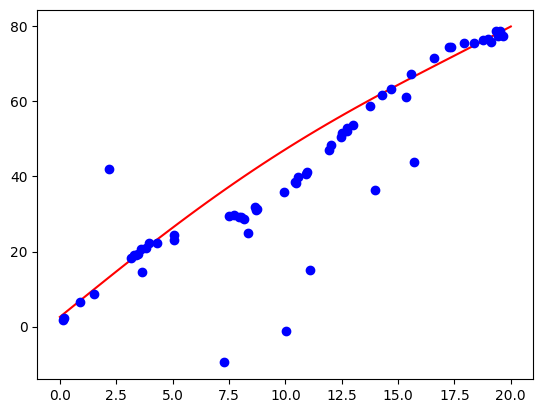

<Figure size 640x480 with 0 Axes>

[2.58828552 3.97119464 5.59237783 0.67116672] 278.98087703573594
[2.58832816 3.97118825 5.59240594 0.67115248] 278.9808770390484
[2.588368   3.97117598 5.59247555 0.67115959] 278.9808770867413
[2.58831267 3.97119276 5.59237512 0.67116061] 278.9808770226693


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 278.9808770226693
             x: [ 2.588e+00  3.971e+00  5.592e+00  6.712e-01]
           nit: 171
          nfev: 298
 final_simplex: (array([[ 2.588e+00,  3.971e+00,  5.592e+00,  6.712e-01],
                       [ 2.588e+00,  3.971e+00,  5.592e+00,  6.712e-01],
                       ...,
                       [ 2.588e+00,  3.971e+00,  5.592e+00,  6.712e-01],
                       [ 2.588e+00,  3.971e+00,  5.592e+00,  6.712e-01]]), array([ 2.790e+02,  2.790e+02,  2.790e+02,  2.790e+02,
                        2.790e+02]))

<Figure size 640x480 with 0 Axes>

In [26]:
np.random.seed(4);run2()